## Prediction Intervals for the CPL
Author: Clara Hoffmann

In [1]:
# load packages
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from helpers import confidence_intervals

In [2]:
# load cdf for each validation observation
va_horse = np.load('../../../../data/commaai/calibration/cpl_dens/va_horse_cdf_is.npy')
hmc_horse = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_horse_cdf_is.npy')
va_ridge = np.load('../../../../data/commaai/calibration/cpl_dens/va_ridge_cdf_is.npy')
hmc_ridge = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_ridge_cdf_is.npy')
mc_dens = np.load('../../../../data/commaai/predictions/mc_dropout/cdf_is_mc_dropout.npy')
mdn_dens = np.load('../../../../data/commaai/predictions/cdf_is_mdn.npy')

In [3]:
# load density, true angles
true_y = np.load('../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')
density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)
# where to evaluate densities
grid = np.linspace(min(density['axes']), max(density['axes']), 750)

In [4]:
# confidence levels
alphas = np.append(np.linspace(0.05, 0.95, 10), float(0.99))

In [5]:
va_horse_ci = confidence_intervals(alphas, va_horse, true_y, grid)
#hmc_horse_ci = confidence_intervals(alphas, hmc_horse, true_y, grid)
va_ridge_ci = confidence_intervals(alphas, va_ridge, true_y, grid)
#hmc_ridge_ci = confidence_intervals(alphas, hmc_ridge, true_y, grid)
mc_ci = confidence_intervals(alphas, mc_dens, true_y, grid)
mdn_ci = confidence_intervals(alphas, mdn_dens, true_y, grid)

 91%|█████████ | 10/11 [00:10<00:01,  1.00s/it]

error at index:4784
error at index:5838
error at index:5839
error at index:7547


  0%|          | 0/11 [00:00<?, ?it/s]

error at index:6964


  9%|▉         | 1/11 [00:01<00:11,  1.16s/it]

error at index:10364
error at index:10459
error at index:10462
error at index:6964


 18%|█▊        | 2/11 [00:02<00:10,  1.19s/it]

error at index:10364
error at index:10398
error at index:10459
error at index:10462
error at index:5786
error at index:6964


 27%|██▋       | 3/11 [00:03<00:08,  1.12s/it]

error at index:10001
error at index:10023
error at index:10301
error at index:10364
error at index:10372
error at index:10398
error at index:10434
error at index:10441
error at index:10455
error at index:10459
error at index:10462
error at index:5786
error at index:5794
error at index:6964


 36%|███▋      | 4/11 [00:04<00:07,  1.08s/it]

error at index:9901
error at index:10001
error at index:10023
error at index:10301
error at index:10364
error at index:10372
error at index:10398
error at index:10434
error at index:10441
error at index:10455
error at index:10459
error at index:10462
error at index:2938
error at index:4186
error at index:4698
error at index:5786
error at index:5794
error at index:6964


 45%|████▌     | 5/11 [00:05<00:06,  1.10s/it]

error at index:9901
error at index:10001
error at index:10023
error at index:10301
error at index:10306
error at index:10364
error at index:10369
error at index:10370
error at index:10372
error at index:10398
error at index:10430
error at index:10434
error at index:10441
error at index:10455
error at index:10459
error at index:10461
error at index:10462
error at index:2938
error at index:4181
error at index:4186
error at index:4698
error at index:5786
error at index:5794
error at index:6782
error at index:6961
error at index:6964


 55%|█████▍    | 6/11 [00:06<00:05,  1.06s/it]

error at index:9213
error at index:9900
error at index:9901
error at index:10001
error at index:10022
error at index:10023
error at index:10026
error at index:10301
error at index:10306
error at index:10339
error at index:10364
error at index:10369
error at index:10370
error at index:10372
error at index:10398
error at index:10430
error at index:10434
error at index:10436
error at index:10441
error at index:10455
error at index:10459
error at index:10461
error at index:10462
error at index:2938
error at index:4181
error at index:4186
error at index:4698
error at index:5786
error at index:5794
error at index:6207
error at index:6686
error at index:6782
error at index:6961
error at index:6962
error at index:6964
error at index:7187
error at index:7190
error at index:7302


 64%|██████▎   | 7/11 [00:07<00:04,  1.04s/it]

error at index:9213
error at index:9900
error at index:9901
error at index:10001
error at index:10002
error at index:10022
error at index:10023
error at index:10026
error at index:10223
error at index:10301
error at index:10306
error at index:10339
error at index:10364
error at index:10369
error at index:10370
error at index:10372
error at index:10398
error at index:10414
error at index:10428
error at index:10429
error at index:10430
error at index:10434
error at index:10435
error at index:10436
error at index:10441
error at index:10452
error at index:10455
error at index:10459
error at index:10461
error at index:10462
error at index:10464
error at index:10467
error at index:961
error at index:1982
error at index:2938
error at index:4181
error at index:4182
error at index:4183
error at index:4186
error at index:4619
error at index:4698
error at index:5786
error at index:5794
error at index:6204
error at index:6205
error at index:6207
error at index:6686
error at index:6782
error at ind

 73%|███████▎  | 8/11 [00:08<00:03,  1.03s/it]

error at index:9213
error at index:9900
error at index:9901
error at index:10001
error at index:10002
error at index:10022
error at index:10023
error at index:10025
error at index:10026
error at index:10223
error at index:10301
error at index:10305
error at index:10306
error at index:10321
error at index:10339
error at index:10346
error at index:10348
error at index:10363
error at index:10364
error at index:10369
error at index:10370
error at index:10372
error at index:10377
error at index:10398
error at index:10414
error at index:10424
error at index:10427
error at index:10428
error at index:10429
error at index:10430
error at index:10432
error at index:10434
error at index:10435
error at index:10436
error at index:10441
error at index:10452
error at index:10454
error at index:10455
error at index:10456
error at index:10458
error at index:10459
error at index:10461
error at index:10462
error at index:10464
error at index:10467
error at index:10468
error at index:961
error at index:198

 82%|████████▏ | 9/11 [00:09<00:02,  1.03s/it]

error at index:10398
error at index:10414
error at index:10424
error at index:10427
error at index:10428
error at index:10429
error at index:10430
error at index:10432
error at index:10434
error at index:10435
error at index:10436
error at index:10441
error at index:10452
error at index:10454
error at index:10455
error at index:10456
error at index:10458
error at index:10459
error at index:10461
error at index:10462
error at index:10464
error at index:10467
error at index:10468
error at index:961
error at index:1982
error at index:2938
error at index:4181
error at index:4182
error at index:4183
error at index:4185
error at index:4186
error at index:4189
error at index:4619
error at index:4698
error at index:4884
error at index:5786
error at index:5794
error at index:5795
error at index:5964
error at index:6096
error at index:6201
error at index:6204
error at index:6205
error at index:6207
error at index:6208
error at index:6686
error at index:6782
error at index:6952
error at index:695

 91%|█████████ | 10/11 [00:10<00:01,  1.03s/it]

error at index:9782
error at index:9899
error at index:9900
error at index:9901
error at index:10001
error at index:10002
error at index:10022
error at index:10023
error at index:10024
error at index:10025
error at index:10026
error at index:10165
error at index:10223
error at index:10301
error at index:10305
error at index:10306
error at index:10307
error at index:10321
error at index:10322
error at index:10333
error at index:10339
error at index:10346
error at index:10348
error at index:10357
error at index:10358
error at index:10359
error at index:10363
error at index:10364
error at index:10369
error at index:10370
error at index:10371
error at index:10372
error at index:10377
error at index:10397
error at index:10398
error at index:10414
error at index:10415
error at index:10424
error at index:10427
error at index:10428
error at index:10429
error at index:10430
error at index:10432
error at index:10434
error at index:10435
error at index:10436
error at index:10438
error at index:10

100%|██████████| 11/11 [00:11<00:00,  1.07s/it]

error at index:9744
error at index:9782
error at index:9899
error at index:9900
error at index:9901
error at index:10001
error at index:10002
error at index:10021
error at index:10022
error at index:10023
error at index:10024
error at index:10025
error at index:10026
error at index:10165
error at index:10223
error at index:10301
error at index:10305
error at index:10306
error at index:10307
error at index:10315
error at index:10321
error at index:10322
error at index:10333
error at index:10338
error at index:10339
error at index:10340
error at index:10341
error at index:10346
error at index:10347
error at index:10348
error at index:10357
error at index:10358
error at index:10359
error at index:10360
error at index:10361
error at index:10363
error at index:10364
error at index:10365
error at index:10368
error at index:10369
error at index:10370
error at index:10371
error at index:10372
error at index:10373
error at index:10377
error at index:10397
error at index:10398
error at index:104

## Prediction Interval Coverage Rates

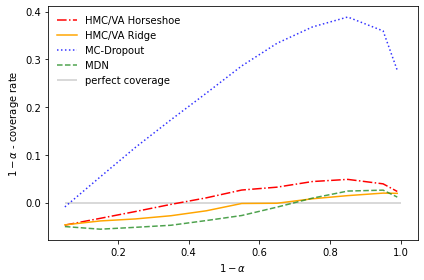

In [7]:
levels = np.append(np.linspace(0.05, 0.95, 10), float(0.99))
plt.hlines(0, 0.05, 1, color = 'black', label ='perfect coverage', alpha = 0.2)
plt.plot(levels, levels - np.array(va_horse_ci['coverage_rate']), linestyle = '-.', label = 'HMC/VA Horseshoe', color = 'red')
#plt.plot(levels, levels - np.array(hmc_horse_ci['coverage_rate']), linestyle = 'dotted', label = 'HMC/Horseshoe', color = 'darkred')
plt.plot(levels, levels - np.array(va_ridge_ci['coverage_rate']), label = 'HMC/VA Ridge', color = 'orange')
plt.plot(levels, levels - np.array(mc_ci['coverage_rate']), linestyle = ':', label = 'MC-Dropout', color = 'blue', alpha = 0.8)
plt.plot(levels, levels - np.array(mdn_ci['coverage_rate']), linestyle = '--', label = 'MDN', color = 'forestgreen', alpha = 0.8)
#plt.plot(levels, levels - np.array(hmc_ridge_ci['coverage_rate']), label = 'HMC/Ridge', color = 'darkorange')
plt.xlabel((r'$1- \alpha$'))
plt.ylabel(r'$1- \alpha$ - coverage rate')
plt.legend()
plt.legend(framealpha=0.0)
plt.tight_layout()
plt.savefig('coverage_rate_cpl_dropout.png', dpi = 300)
# coverage rate is actually higher than predicted coverage rate

## PI width

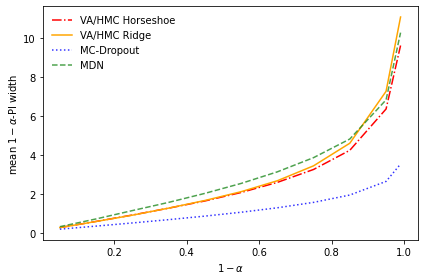

In [9]:
plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(va_horse_ci['pred_int_width'])), axis = 1), label = 'VA/HMC Horseshoe', color = 'red', linestyle = '-.')
#plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(hmc_horse_ci['pred_int_width'])), axis = 1), label = 'HMC/Horseshoe', linestyle = 'dotted',color = 'darkred')
plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(va_ridge_ci['pred_int_width'])), axis = 1), label = 'VA/HMC Ridge',  color = 'orange')
plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(mc_ci['pred_int_width'])), axis = 1), label = 'MC-Dropout', linestyle = ':',  color = 'blue', alpha = 0.8)
plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(mdn_ci['pred_int_width'])), axis = 1), label = 'MDN', linestyle = '--',  color = 'forestgreen', alpha = 0.8)
#plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(hmc_ridge_ci['pred_int_width'])), axis = 1), label = 'HMC/Ridge', color = 'darkorange')
plt.xlabel((r'$1- \alpha$'))
plt.ylabel(r'mean $1 - \alpha$-PI width')
plt.legend()
plt.legend(framealpha=0.0)
plt.tight_layout()
plt.savefig('mean_pi_width_cpl.png', dpi = 300)